# Microsoft Movie Analysis

**Authors:** Kevin Culver
***

## Overview

The project analyzes various movie databases to provide tangible steps for Microsoft to take as it begins to create movie content. Analysis of these databases showed that certain characteristics of a movie, such as its genre, budget, or run time produced greater profit. Analysis also revealed common trends that top-grossing films share. These findings can be used by Microsoft to narrow down decisions on what types of films to produce and invest in.

## Business Problem

Creating a successful movie takes time, money, and risk. However, a company, like Microsoft, cannot predict how the movie will be received by it's audience. Therefore, the point of my analysis was to find what qualities are shared by high grossing films. to provide insight into what characteristics of movies have the greatest likelihood of monetary success. Using this data, I provide recommendations... 
***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

The data used in this project comes from three online movie databases - iMDB, The Numbers, and Box Office Mojo. Within these databases, each movie is identified by its title or movie id. When combined, these databases provide comprehensive information for each movie, including its rating, release date, budget, gross (both domestic and worldwide), genre and other characteristics. 


### Importing Relevant Modules and Datasets

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

%matplotlib inline

In [2]:
#iMDB datasets
imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
imdb_titles = pd.read_csv('zippedData/imdb.title.basics.csv.gz')

#The Numbers (movie budget dataset)
budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

### iMDB and The Numbers Datasets

#### iMDB Data
Two datasets imported from iMDB are: *imdb_ratings* and *imdb_titles*. 

The *imdb_ratings* database, provides the average ratings and number of votes for each movies.  

The second database, *imdb_titles*, provides more info on each movie including it's title, runtime, start year, and genre. 


These two datasets can be easily joined since they share the unique movie identifier 'tconst'. In the cells below, the iMDB databases are joined using an inner join. 

In [3]:
#setting indexes to 'tconst' for each dataset to prep for inner join
imdb_titles.set_index('tconst', inplace=True)
imdb_ratings.set_index('tconst', inplace=True)

In [4]:
#joining dfs using inner join to get iMDB movies that contain both titles and ratings
imdb_titles_ratings = imdb_titles.join(imdb_ratings, how='inner')

imdb_titles_ratings.head(2)


,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
tconst,,,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43


At this point in the analysis, there are close to 74,000 entries. The start year's range from 2010-2019, but as we'll see this is column does not represent the movie's actual release date. 

#### The Numbers Data:

'The Numbers' dataset includes information on each movie's release date, title, budget, and total gross(both domestic and worldwide). The dataset contains 5782 entries.

In [5]:
budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


#### Merging Datasets

The two tables are joined using movie title to create one movie data frame. Before cleaning the data frame has 2638 entries. With movies' release date ranging from 1940-2019.

In [6]:
#merging the two tables (imdb + budget) using movie titles
movies_df = pd.merge(imdb_titles_ratings, budget, right_on='movie', left_on='original_title')
movies_df.head(2)

,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,The Overnight,The Overnight,2010,88.0,NaN,7.5,24,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"


### Creating Top 2021 Movies Dataset Using Webscraping

Since the data from the tables above only includes movies up to 2019, I wanted to get more recent data. To do so, I webscraped data from the website boxofficemojo.com to from a table with the top 200 movies from 2021.

The data includes the movie's current rank, title, gross, release date, and studio.

In [7]:
html_page = requests.get("https://www.boxofficemojo.com/year/2021/?ref_=bo_lnav_hm_shrt")

soup = BeautifulSoup(html_page.content, 'html.parser')

In [8]:
#finding relevant division and creating container
table = soup.find('div', id='table')

#seperates all the relevant rows with movie data from table headers
table_rows = table.findAll('tr')[1:]

#length outputs 200 items, which corresponds to the 200 items on the website
len(table_rows)

200

In [9]:
#finding rank
rank = table_rows[0].find('td', class_="a-text-right mojo-header-column mojo-truncate mojo-field-type-rank mojo-sort-column").text

#finding title
title = table_rows[0].find('td', class_= "a-text-left mojo-field-type-release mojo-cell-wide").text

#finding amount grossed
gross = table_rows[0].find('td', class_ = "a-text-right mojo-field-type-money mojo-estimatable").text

#finding release date
release_date = table_rows[0].find('td', class_ = "a-text-left mojo-field-type-date a-nowrap").text

#finding studio
studio =  table_rows[0].find('td',class_ = "a-text-left mojo-field-type-studio").text.strip()


In [10]:
#Function to retrieve each row/movie from website
def get_movie_data(movie_table):
    movie_data = []
    for row in movie_table:
        rank = row.find('td', class_="a-text-right mojo-header-column mojo-truncate mojo-field-type-rank mojo-sort-column").text
        title = row.find('td', class_= "a-text-left mojo-field-type-release mojo-cell-wide").text
        gross = row.find('td', class_ = "a-text-right mojo-field-type-money mojo-estimatable").text
        release_date = row.find('td', class_ = "a-text-left mojo-field-type-date a-nowrap").text
        studio = row.find('td',class_ = "a-text-left mojo-field-type-studio").text.strip()
        
        movie_data.append({'Rank': rank, 'Title': title, 'Gross': gross, 
                           'Release Date': release_date, 'Studio': studio})
    return movie_data

In [25]:
movie_data = get_movie_data(table_rows)
rankings_2021_df = pd.DataFrame(movie_data)

rankings_2021_df.head()

,Rank,Title,Gross,Release Date,Studio
0,1,Shang-Chi and the Legend of the Ten Rings,"$223,361,907",Sep 3,Walt Disney Studios Motion Pictures
1,2,Venom: Let There Be Carnage,"$193,717,635",Oct 1,Sony Pictures Entertainment (SPE)
2,3,Black Widow,"$183,651,655",Jul 9,Walt Disney Studios Motion Pictures
3,4,F9: The Fast Saga,"$173,005,945",Jun 25,Universal Pictures
4,5,A Quiet Place Part II,"$160,072,261",May 28,Paramount Pictures


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

### Data Cleaning:

#### Changing data types:
Any column that deals with total gross ($) is converted from an object dtype into an integer dtype to make for easier analysis.

With these dtype changes, a new column 'production_profit' is created to measure the actual profit of each movie after accounting for the cost of budget.

A column, 'date_released' is also added that changes the release date to a datetime object to make analysis easier.

In [12]:
#Function to tranform money columns into cleaned integers dtyes
def money_cleaner(df, column_name, new_col_name):
    df[new_col_name] = df[column_name].map(lambda x: x.replace('$', ''))
    df[new_col_name] = df[new_col_name].map(lambda x: x.replace(',', ''))
    df[new_col_name] = pd.to_numeric(df[new_col_name])
    
    return df[new_col_name]

In [13]:
#cleaning budget column
budget_clean = money_cleaner(movies_df, 'production_budget', 'budget_clean')
movies_df['budget_clean'] = budget_clean

#cleaning worldwide_gross column
worldwide_gross = money_cleaner(movies_df, 'worldwide_gross', 'ww_gross_clean')
movies_df['ww_gross_clean'] = worldwide_gross

movies_df.head()

,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_clean,ww_gross_clean
0,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706",45000000,73706
1,The Overnight,The Overnight,2010,88.0,NaN,7.5,24,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996",200000,1165996
2,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996",200000,1165996
3,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302",25000000,9313302
4,On the Road,On the Road,2014,89.0,Drama,6.0,6,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302",25000000,9313302


In [14]:
#Creates a production_profit column to determine how much profit each movie made
#after budget accounted for
movies_df['production_profit'] = movies_df['ww_gross_clean'] - movies_df['budget_clean']


In [15]:
#creating column with release date as datetime object
movies_df['date_released'] = pd.to_datetime(movies_df['release_date'])



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2638 entries, 0 to 2637
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   primary_title      2638 non-null   object        
 1   original_title     2638 non-null   object        
 2   start_year         2638 non-null   int64         
 3   runtime_minutes    2532 non-null   float64       
 4   genres             2633 non-null   object        
 5   averagerating      2638 non-null   float64       
 6   numvotes           2638 non-null   int64         
 7   id                 2638 non-null   int64         
 8   release_date       2638 non-null   object        
 9   movie              2638 non-null   object        
 10  production_budget  2638 non-null   object        
 11  domestic_gross     2638 non-null   object        
 12  worldwide_gross    2638 non-null   object        
 13  budget_clean       2638 non-null   int64         
 14  ww_gross

***
The 'start_year' column is misleading. It does not always represent the actual release date. 
For example: "Action Jackson" came out in 1988, but the start date listed is 2014.

In the cell below, I correct the 'start_year' column by replacing it with the accurate year from 'release_date' column instead.

In [16]:
#replacing stary_year with correct year
movies_df['start_year'] = movies_df['release_date'].map(lambda x: x[-4:])

#The last step is to convert the column into an int64 dtype
movies_df['start_year'] = pd.to_numeric(movies_df['start_year'])


#### Dropping Unnecessary Columns

In [17]:
movies_df.drop(labels=['original_title', 'id', 'movie', 'release_date', 
                       'production_budget', 'domestic_gross', 
                       'worldwide_gross'], axis=1, inplace=True)

#### Removing Duplicates and Null Values

There are 5 items without genres and 106 items without runtime with 2638 items in total. Since there are only 5 without genre, these items are dropped. 

Runtime is not used in this analysis, so no action is taken for the null values.


In [18]:
movies_df.head()

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,budget_clean,ww_gross_clean,production_profit,date_released
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31
1,The Overnight,2015,88.0,NaN,7.5,24,200000,1165996,965996,2015-06-19
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19
3,On the Road,2013,124.0,"Adventure,Drama,Romance",6.1,37886,25000000,9313302,-15686698,2013-03-22
4,On the Road,2013,89.0,Drama,6.0,6,25000000,9313302,-15686698,2013-03-22


In [19]:
movies_df.dropna(subset=['genres'], inplace=True)

In [20]:
movies_df.duplicated(subset='primary_title').sum()

541

There are 541 duplicate titles in the dataset that need to be dropped, which then brings the total number of entries to 2092. 

In [23]:
movies_df.drop_duplicates(keep='first', subset='primary_title', inplace=True)

#Sucessfully dropped duplicate entries
movies_df.shape

(2092, 10)

### Separating Genres and Creating New Data Frame
Each movie can have multiple genre designations. These designations are clumped together in a list and need to be separated for better, more accurate analysis. 

In [24]:
#Splits/seperates each genre category for each movie/row
movies_df['genres_list'] = movies_df['genres'].map(lambda x: x.split(','))
movies_df.head(2)

#Creates new df with each genre category represented in a row
genres_df = movies_df.explode('genres_list')
genres_df.head(5)

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,budget_clean,ww_gross_clean,production_profit,date_released,genres_list
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Action
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Animation
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Comedy
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19,Comedy
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19,Mystery


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### Most Profitable Movie Genres

Explanation...

In [26]:
# Orders the genres from most profitable to least. To be used in sns barplot
genre_means = genres_df.groupby('genres_list').mean()['production_profit']\
                                    .sort_values(ascending=False)
genre_means.index

Index(['Animation', 'Adventure', 'Sci-Fi', 'Action', 'Fantasy', 'Musical',
       'Family', 'Comedy', 'Thriller', 'Mystery', 'Music', 'Sport',
       'Biography', 'Horror', 'Crime', 'Drama', 'Romance', 'History',
       'Western', 'War', 'Documentary'],
      dtype='object', name='genres_list')

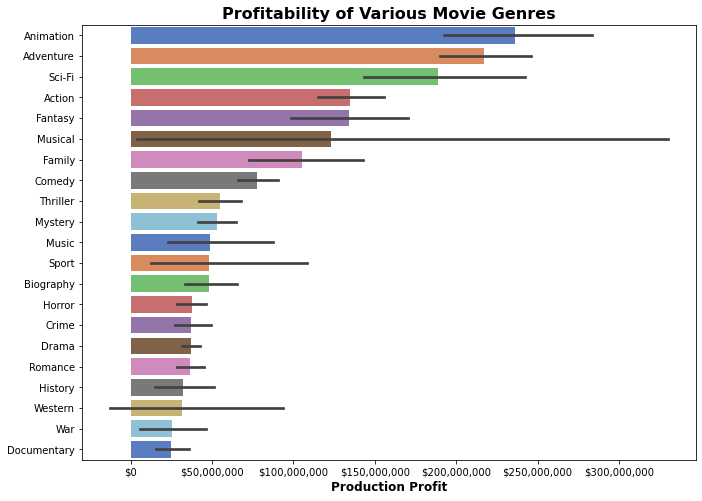

In [27]:
ax = sns.barplot(data=genres_df, y='genres_list', x='production_profit', 
                 order=genre_means.index, palette='muted')


ax.get_figure().set_size_inches((11, 8))

##?? HOW to order by profit rather than genre category?? 
ax.set_xlabel('Production Profit', fontsize=12, fontweight='bold')
ax.xaxis.set_major_formatter("${x:,.0f}")

##?? HOW to rotate xlabels?

ax.set_ylabel(ylabel=None)

ax.set_title('Profitability of Various Movie Genres', fontsize=16, fontweight='bold')

plt.savefig('./images/genre_profit.png', facecolor='white');

### The Impact of Budget Size on Movie Profit

Explanation...

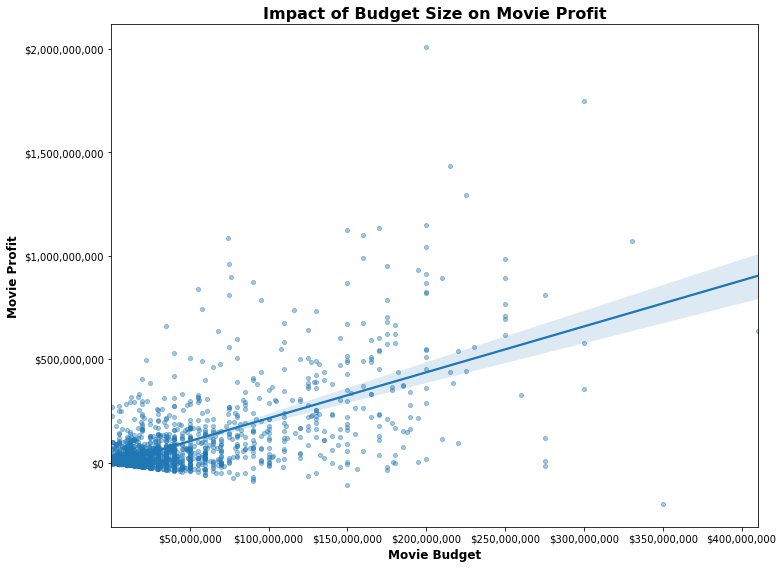

In [31]:
fig, ax = plt.subplots(figsize=(11,8))


#Average movie profit scatterplot
sns.regplot(data=movies_df, x='budget_clean', y='production_profit', 
                     scatter_kws = dict(alpha=0.4, s=17))

ax.set_xlabel('Movie Budget', fontsize=12, fontweight='bold')
ax.xaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel('Movie Profit', fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_title('Impact of Budget Size on Movie Profit', fontsize=16, fontweight='bold');

### The Impact of Ratings on Profit

Explanation

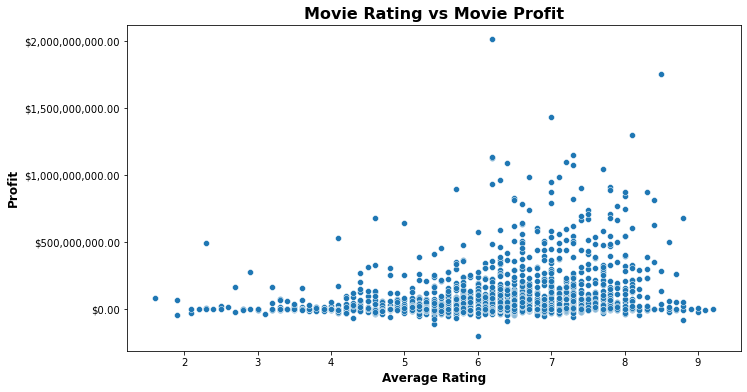

In [34]:
fig, ax = plt.subplots(figsize=(11,6))
plt.xticks()
ax = sns.scatterplot(data=movies_df,
                  y='production_profit', x='averagerating')
#alpha=0.7, s=27)

ax.set_xlabel('Average Rating', fontsize=12, fontweight='bold')
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha='right')

ax.set_ylabel('Profit', fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter("${x:,.2f}")
ax.set_title("Movie Rating vs Movie Profit", fontsize=16, fontweight='bold');

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***